In [ ]:
import math
import data
import random
import plotly.express as px

### Part 2: Scalar backpropagation

##### Question 3

In [325]:
def forward_pass(W, V, X, t_index, b, c):
    k, h = [0., 0., 0.], [0., 0., 0.]
    o, y = [0., 0.], [0., 0.]
    
    # linear
    for j in range(3):
        for i in range(2):
            k[j] += W[i][j] * X[i]
        k[j] += b[j]

    # sigmoid activation
    for i in range(3):
        h[i] = (1+math.exp(-k[i]))**(-1)

    # linear
    for i in range(2):
        for j in range(3):
            o[i] += h[j] * V[j][i]
        o[i] += c[i]

    #softmax activation
    sum_exp_output = sum([math.exp(output) for output in o])
    for i in range(2):
        y[i] = math.exp(o[i])/ sum_exp_output

    # compute loss
    loss = (-1*math.log(y[t_index]))

    context = W, V, X, t_index, b, c, k, h, o, y
    return loss, context

In [326]:
def backward_pass(context, alpha=0.01):
    W, V, X, t_index, b, c, k, h, o, y = context
    dy, do = [0., 0.], [0., 0.]
    dV, dW = [[0., 0.], [0., 0.], [0., 0.]], [[0., 0. , 0.], [0., 0., 0.]]
    dh, dk = [0. , 0., 0.], [0. , 0., 0.]
    db = [0., 0., 0.]

    # compute d(Loss)/dy[i]
    for i in range(2):
        if i == t_index: dy[i] = -1/y[i]
        else: dy[i] = 0

    # compute d(Loss)/do[i]
    for i in range(2):
        for j in range(2):
            if i != j and i == t_index:
                do[j] += dy[i]*(-1)*y[i]*y[j]
            elif i == j and i == t_index:
                do[j] += dy[i]*y[i]*(1-y[i])
            elif i != t_index:
                do[j] += 0

    # compute d(Loss)/dV[j][i] and d(Loss)/dh[i]
    for i in range(2):
        for j in range(3): 
            dV[j][i] = do[i]*h[j]
            dh[j] += do[i]*V[j][i]
    dc = do

    # compute d(Loss)/dk[i]
    for j in range(3):
        dk[j] = dh[j] * h[j] * (1-h[j])

    # compute d(Loss)/dW[i][j] and d(Loss)/db[j]
    for j in range(3):
        for i in range(2):
            dW[i][j] = dk[j] * X[i]
        db[j] = dk[j]

    for j in range(3):
        for i in range(2):
            W[i][j] += -alpha*dW[i][j]
        b[j] += -alpha*db[j]

    for i in range(2):
        for j in range(3): 
            V[j][i] += -alpha*dV[j][i]
        c[i] += -alpha*dc[i]

    results = W, V, b, c
    gradients = dy, do, dh, dk, dV, dW, db, dc
    return gradients, results

In [327]:
## Test forward pass
W, V= [[1.,1.,1.], [-1,-1,-1]], [[1.,1.], [-1.,-1.], [-1., -1.]]
b, c = [0, 0, 0], [0, 0]
X, t = [1, -1], 0
loss = 0

loss, context = forward_pass(W, V, X, t, b, c)
print("Loss: ", loss)

## Test backward pass
gradients, results = backward_pass(context)
dy, do, dh, dk, dV, dW, db, dc = gradients

print("Gradient of W: ", dW)
print("Gradient of b: ", db)
print("Gradient of V: ", dV)
print("Gradient of c: ", dc)

print(results)

Loss:  0.6931471805599453
Gradient of W:  [[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]]
Gradient of b:  [0.0, 0.0, 0.0]
Gradient of V:  [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
Gradient of c:  [-0.5, 0.5]
([[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]], [[1.0044039853898894, 0.9955960146101106], [-0.9955960146101106, -1.0044039853898894], [-0.9955960146101106, -1.0044039853898894]], [0.0, 0.0, 0.0], [0.005, -0.005])


##### Question 4

In [328]:
(xtrain, ytrain), (xval, yval), num_cls = data.load_synth()

In [329]:
def convert_onehotencoding(ydata):
    t = [0, 0]
    t[ydata] = 1
    return t

In [330]:
def initialize_weights(is_random=True):
    r = random.gauss # mu=0 and sigma=1
    if not is_random:
        W, V= [[1.,1.,1.], [-1,-1,-1]], [[1.,1.], [-1.,-1.], [-1., -1.]]
        b, c = [0, 0, 0], [0, 0]
    else:
        W, V= [[r(0,1),r(0,1),r(0,1)], [r(0,1),r(0,1),r(0,1)]], [[r(0,1),r(0,1)], [r(0,1),r(0,1)], [r(0,1),r(0,1)]]
        b, c = [0, 0, 0], [0, 0]
    
    return W, V, b, c

In [331]:
W, V, b, c = initialize_weights(is_random=True)

# save loss values for train and validation
avg_loss_train, avg_loss_val = [], []
loss_train_epoch1, loss_val_epoch1 = [], []
epochs = 10
alpha = 0.01 # learning rate

for epoch in range(epochs):
    # train data
    loss_train, loss_val = [], []
    for X, t_index in zip(xtrain, ytrain): 
        loss, context = forward_pass(W, V, list(X), t_index, b, c)
        
        gradients, results = backward_pass(context, alpha)
        W, V, b, c  = results

        loss, context = forward_pass(W, V, list(X), t_index, b, c)
        loss_train.append(loss)

    # validation data
    for X, t_index in zip(xval, yval): 
        loss, context = forward_pass(W, V, list(X), t_index, b, c)
        loss_val.append(loss)

    avg_loss_train.append(sum(loss_train)/len(loss_train))
    avg_loss_val.append(sum(loss_val)/len(loss_val))


In [332]:
import pandas as pd

avg_loss = []
vector_epochs = [i for i in range(len(avg_loss_train))]
avg_loss += avg_loss_train
name = ['train' for _ in range(len(avg_loss_train))]
vector_epochs += [i for i in range(len(avg_loss_val))]
avg_loss += avg_loss_val
name += ['val' for _ in range(len(avg_loss_val))]

df = pd.DataFrame({'epochs': vector_epochs,'avg_loss': avg_loss, 'name': name})
fig = px.line(df, x='epochs', y='avg_loss', color='name', markers=True)
fig.show()

In [ ]:
# TODO CHECK WHICH PLOT WE NEED

# samples = [i for i in range(len(loss_train_epoch1))]
# loss_epoch1 = loss_train_epoch1
# name = ['train' for _ in range(len(loss_train_epoch1))]

# df = pd.DataFrame({'samples': samples,'loss_epoch1': loss_epoch1, 'name': name})
# fig = px.line(df, x='samples', y='loss_epoch1', color='name', markers=True)
# fig.show()

### Part 3: Tensor backpropagation

In [341]:
import numpy as np
from tqdm.auto import tqdm 

In [342]:
def sigmoid(x):
  return ((1+np.exp(-x))**(-1)).reshape(-1, 1)

In [453]:
def normalize_data(dataset):
  return (dataset - dataset.min()) / (dataset.max() - dataset.min())

In [454]:
def standardize_data(dataset):
  return (dataset - dataset.mean()) / dataset.std()

In [450]:
test = normalize_data(x_train)

In [ ]:
test[0].shape

In [356]:
def initialize_weights_vector(input_size, nr_classes=10, nr_hlayers=300):    
    W = np.array(np.random.normal(0, 1, size=(nr_hlayers, input_size)), dtype=np.float128) 
    V = np.array(np.random.normal(0, 1, size=(nr_classes, nr_hlayers)), dtype=np.float128)
    b, c = (np.array([0.]*nr_hlayers, dtype=np.float128).reshape(-1, 1)), (np.array([0.]*nr_classes, dtype=np.float128).reshape(-1, 1))
    
    return W, V, b, c

##### Question 5

In [449]:
(x_train, y_train), (x_val, y_val), num_mcls = data.load_mnist()

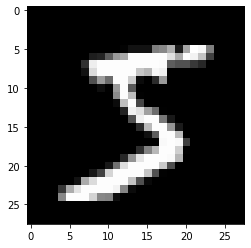

In [379]:
# visualize the data
import matplotlib.pyplot as plt

img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

In [484]:
def forward_pass_vectorized(W, V, X, t_index, b, c):    
    # linear
    k = W.dot(X) + b

    # sigmoid activation
    h = sigmoid(k)

    # linear
    o = V.dot(h) + c

    # softmax activation
    exp_o = np.exp(o)
    y = exp_o/np.sum(exp_o)

    # compute loss
    loss = np.sum(-1*np.log(y[t_index]))

    context = W, V, X, t_index, b, c, k, h, o, y
    return loss, context

In [485]:
def backward_pass_vectorized(context, nr_classes = 10, alpha=0.01):
    W, V, X, t_index, b, c, k, h, o, y = context
    dy = np.array([0.]*nr_classes, dtype=np.float128).reshape(-1, 1)
    y = np.array(y, dtype=np.float128).reshape(-1, 1)

    # compute d(Loss)/dy[i]
    dy[t_index] = -1/y[t_index]

    # compute d(Loss)/do[i] TODO
    # https://mmuratarat.github.io/2019-01-27/derivation-of-softmax-function
    # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
    # https://davidbieber.com/snippets/2020-12-12-derivative-of-softmax-and-the-softmax-cross-entropy-loss/
    # Since exactly one of the s is 1 and the rest are zeros this further simplifies to:
    # t = np.zeros(nr_outputs)
    # t[t_index] = 1
    # do = y - t
    # d(Loss)/do[i]
    do = ((y * np.identity(y.size) - y @ y.T) @ dy)
    # compute d(Loss)/dV[j][i] and d(Loss)/dh[i]
    dV = do @ (h.T)
    dh = V.T @ do
    dc = do

    # compute d(Loss)/dk[i]
    dk = dh * h * (1-h)

    # compute d(Loss)/dW[i][j] and d(Loss)/db[j]
    dW = dk @ X.T
    db = dk

    W += -alpha*dW
    b = b -alpha*db
    V += -alpha*dV
    c = c - alpha*dc

    results = W, V, b, c
    gradients = dy, do, dh, dk, dV, dW, db, dc
    return gradients, results

In [486]:
# Test vectorized version
W, V= np.array([[1.,-1.], [1.,-1.], [1.,-1.]]), np.array([[1., -1, -1 ], [1., -1, -1]])
b, c = np.array([0, 0, 0]).reshape(-1, 1), np.array([0, 0]).reshape(-1, 1)
X, t_index = np.array([1, -1]).reshape(-1, 1), 0

loss, context = forward_pass_vectorized(W, V, X, t_index, b, c)
print("Loss: ", loss)
# W, V, X, t_index, b, c, k, h, o, y  =context
# print("Context: ", h)

gradients, results = backward_pass_vectorized(context, 2)
dy, do, dh, dk, dV, dW, db, dc = gradients

print("Gradient of W: ", dW)
print("Gradient of b: ", db)
print("Gradient of V: ", dV)
print("Gradient of c: ", dc)

print(results)
#([[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]], [[1.0044039853898894, 0.9955960146101106], [-0.9955960146101106, -1.0044039853898894], [-0.9955960146101106, -1.0044039853898894]], [0.0, 0.0, 0.0], [0.005, -0.005])


Loss:  0.6931471805599453
Gradient of W:  [[0. 0.]
 [0. 0.]
 [0. 0.]]
Gradient of b:  [[0.]
 [0.]
 [0.]]
Gradient of V:  [[-0.44039854 -0.44039854 -0.44039854]
 [ 0.44039854  0.44039854  0.44039854]]
Gradient of c:  [[-0.5]
 [ 0.5]]
(array([[ 1., -1.],
       [ 1., -1.],
       [ 1., -1.]]), array([[ 1.00440399, -0.99559601, -0.99559601],
       [ 0.99559601, -1.00440399, -1.00440399]]), array([[0.],
       [0.],
       [0.]], dtype=float128), array([[ 0.005],
       [-0.005]], dtype=float128))


In [422]:
# (x_train, y_train), (x_val, y_val), num_mcls = data.load_synth()

In [487]:
W, V, b, c = initialize_weights_vector(x_train.shape[1], nr_classes=num_mcls, nr_hlayers=3)
x_train, x_val = normalize_data(x_train), normalize_data(x_val)

# save loss values for train and validation
avg_loss_train, avg_loss_val = [], []
epochs = 10
alpha = 0.01 # learning rate

for epoch in tqdm(range(epochs), desc='epochs'):
    # train data
    loss_train, loss_val = [], []
    for (X, t_index) in tqdm(zip(x_train, y_train), total=y_train.size, desc='train'):
        X = np.array(X, dtype=np.float128).reshape(-1, 1)
        loss, context = forward_pass_vectorized(W, V, X, t_index, b, c)

        gradients, results = backward_pass_vectorized(context, nr_classes=num_mcls, alpha=alpha)
        W, V, b, c  = results
        
        loss, _ = forward_pass_vectorized(W, V, X, t_index, b, c)
        loss_train.append(loss)

    # validation data
    for X, t_index in tqdm(zip(x_val, y_val), total=y_val.size, desc='test'): 
        X = np.array(X, dtype=np.float128).reshape(-1, 1)
        loss, _ = forward_pass_vectorized(W, V, X, t_index, b, c)
        loss_val.append(loss)

    avg_loss_train.append(sum(loss_train)/len(loss_train))
    avg_loss_val.append(sum(loss_val)/len(loss_val))


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/55000 [00:00<?, ?it/s]

test:   0%|          | 0/5000 [00:00<?, ?it/s]

In [488]:
# avg_loss_train =2.2953103413377390614, avg_loss_val = 2.3029150283927041403
avg_loss = []
vector_epochs = [i for i in range(len(avg_loss_train))]
avg_loss += [float(item) for item in avg_loss_train]
name = ['train']*len(avg_loss_train)
vector_epochs += [i for i in range(len(avg_loss_val))]
avg_loss += [float(item) for item in avg_loss_val]
name += ['val']*len(avg_loss_val)
print(len(vector_epochs), len(avg_loss), len(name))

df = pd.DataFrame({'epochs': vector_epochs,'avg_loss': avg_loss, 'name': name})
fig = px.line(df, x='epochs', y='avg_loss', color='name', markers=True)
fig.show()

20 20 20


##### Question 6

### Part 4: Analysis

##### Question 7.1

##### Question 7.2

##### Question 7.3

##### Question 7.4